# imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import warnings; warnings.filterwarnings(action='ignore')
# --------------------------------------------------

# --------------------------------------------------
# load datasets
from sklearn import datasets

# imblearn.sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

# preprocessing.encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder # pd.get_dummies()
# preprocessing.scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
# preprocessing.binarizing
from sklearn.preprocessing import Binarizer

# decomposition.PCA
from sklearn.decomposition import PCA


# Classifier ---------------------------------------

# estimators
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression # classifier
from xgboost import XGBClassifier, XGBRFClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
# metrics.scores
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import log_loss
# metrics.curves
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import roc_curve, plot_roc_curve
# metrics.reports
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
# --------------------------------------------------

# Regressor-----------------------------------------
# estimators
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from xgboost import XGBRegressor, XGBRFRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, CatBoostError
# metrics.errors
from sklearn.metrics import mean_squared_error     # 'neg_mean_squared_error', 'neg_root_mean_squared_error'
from sklearn.metrics import mean_squared_log_error # 'neg_mean_squared_log_error'
from sklearn.metrics import mean_absolute_error    # 'neg_mean_absolute_error'
# --------------------------------------------------

# stats : R module
from scipy.stats import skew, kurtosis

# model_selection.splitter
from sklearn.model_selection import train_test_split       # function
# model_selection.model_validation
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold # cross-validator
from sklearn.model_selection import cross_val_score
# model_selection.hyper_parameter_optimizer
from sklearn.model_selection import GridSearchCV

# **************************************************

# --------------------------------------------------
def check_nan(df):
    nan = df.isna().sum()[df.isna().sum() != 0]
    nan_cols = list(nan.index)
    nan_cnt  = df[nan_cols].isna().sum()
    rate = round(nan_cnt / df.shape[0] * 100, 2)
    nan_df = pd.DataFrame({'NAN_CNT':nan_cnt, 'RATE':rate})
    
    print(nan_df)
    print('-' * 30)
    print('nan_cols count =', len(nan_cols))
    print(nan_cols)
 
    for col in nan_cols:
        print('-' * 30)
        print(df[col].value_counts())
        print('value_counts =', df[col].count(), '/ nan_counts =', df[col].isna().sum())
    
    return nan_cols
# nan_cols = check_nan(df)
# --------------------------------------------------

# --------------------------------------------------
def check_outliers(X_train, features, rate=1.5):
    
    dict = {}
    
    for col in features:
        
        Q1 = np.percentile(X_train[col], 25) 
        Q3 = np.percentile(X_train[col], 75) 
        IQR = Q3 - Q1
        
        min = Q1 - (rate * IQR)
        max = Q3 + (rate * IQR)
        
        idxs = X_train[(X_train[col] < min) | (X_train[col] > max)].index
        
        dict[col] = idxs
        
    return dict
# check_outliers(X_train, 'Insulin')
# --------------------------------------------------

# --------------------------------------------------
def check_object(df):
    object_cols = list(df.dtypes[df.dtypes == 'object'].index)
    print('object_cols count =', len(object_cols))
    for col in object_cols:
        print('-' * 30)
        print(df[col].value_counts())
    return object_cols
# object_cols = encode(df)
# --------------------------------------------------

# --------------------------------------------------
def mapping(df, col, dict):
    dict = {}
    
    for i in range(len(df[col].value_counts().index)):
        dict[df[col].value_counts().index[i]] = i
    
    df['e_' + col] = df[col].map(dict)
    return df['e_' + col].value_counts()
# mapping(df, 'gender')
# --------------------------------------------------

# --------------------------------------------------
def split_xy(df, target, test_size=0.2):
    
    """split X, y & train, test"""
    
    X = df.drop(target, axis=1)
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0, stratify=y)
    
    return X_train, X_test, y_train, y_test

# X_train, X_test, y_train, y_test = split_xy(df, 'Outcome')
# --------------------------------------------------

# --------------------------------------------------
def scores(y_test, y_pred):
    
    """evaluation scores"""
    
    f1        = f1_score         (y_test, y_pred, average='macro')
    accuracy  = accuracy_score   (y_test, y_pred, )
    precision = precision_score  (y_test, y_pred, average='macro')
    recall    = recall_score     (y_test, y_pred, average='macro')
    c_matrix  = confusion_matrix (y_test, y_pred, )
    
    print(
          f'accuracy  = {accuracy:.6f},  '
          f'f1 score  = {f1:.6f},  \n'
          f'precision = {precision:.6f},  '
          f'recall    = {recall:.6f},')
    print(c_matrix)
    
    # plt.figure(figsize=(12, 9))
    # plt.title('confusion matrix')
    # plt.xlabel('Predict')
    # plt.ylabel('Actual')
    # sns.heatmap(c_matrix, annot=True, linewidths=1, cmap='Blues', annot_kws={"size": 14})
    # plt.show()
# --------------------------------------------------

# --------------------------------------------------
def curves(y_test, probas_pred):
        
    FPRS, TPRS, thresholds = roc_curve(y_test, probas_pred[:, 1])
 
    f, ax = plt.subplots(1, 2, figsize=(16, 6))
 
    # settings
    plt.subplot(121)
    plt.title('ROC curve')
    plt.gray()
    plt.xlabel('FPR(1- specificity)')
    plt.ylabel('TPR')
 
    # x, y values
    plt.plot(FPRS, TPRS, label='ROC', linestyle='solid')
    plt.plot([0, 1], [0, 1], label='50%', color='gray', linestyle=':')
    plt.legend()
 
    precisions, recalls, thresholds = precision_recall_curve(y_test, probas_pred[:, 1])
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
 
    plt.subplot(122)
    plt.title('precision recall curve')
    plt.gray()
    plt.xlabel('threshold')
    plt.ylabel('scores')
 
    # x, y values
    plt.plot(thresholds, precisions[:thresholds.shape[0]], label='precision', linestyle=':')
    plt.plot(thresholds, recalls[:thresholds.shape[0]],    label='recall',    linestyle='--')
    plt.plot(thresholds, f1_scores[:thresholds.shape[0]],  label='f1',        linestyle='solid')
    # valid linestyle = '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'
    plt.legend()
 
    plt.show()
    
    print('AUC = ', roc_auc_score(y_test, probas_pred[:, 1]))
# --------------------------------------------------
# --------------------------------------------------

In [4]:
# # GridsearchCV : INPUT DF VERSION
# df_met = df01

# # (train, sub) & (X, y) & (train, tset) split
# train_met = df_met[df_met['credit'].notna()]

# X = train_met.drop('credit', axis=1)
# y = train_met['credit']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0,
#                                                     shuffle=True, stratify=y)

# # models
# models = [
#           RandomForestClassifier(),
#         #   GradientBoostingClassifier(), 
#         #   XGBClassifier(), 
#         #   XGBRFClassifier(), 
#         #   LGBMClassifier(), 
#         #   CatBoostClassifier(),
#           ]

# # param_grid=
# hyper_param = {'n_estimators':[400],
#                'random_state':[0],
#                'min_samples_split':[4],
#                'min_samples_leaf':[1],
#                }

# # scoring=
# scorers = {'f1_macro':'f1_macro', 'accuracy':'accuracy',
#            'precision':'precision_macro', 'recall':'recall_macro', 'roc_auc_ovr':'roc_auc_ovr',}
# # cv=
# skfold  = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# # cv_results_ cols
# result_scorers = ['mean_test_f1_macro', 'mean_test_accuracy', 
#                   'mean_test_precision', 'mean_test_recall', 'mean_test_roc_auc_ovr',]

# # GridSearchCV loop
# for model in models:
        
#         gscv = GridSearchCV(model, param_grid=hyper_param, scoring=scorers, refit='f1_macro', cv=skfold, return_train_score=True)
#         gscv.fit(X, y)
#         results = gscv.cv_results_
        
#         print('-' * 75)
#         print('estimtor        =', gscv.estimator)
#         print('best_params_    =', gscv.best_params_)
#         print('best_score_     =', gscv.best_score_)
        
#         met_df = pd.DataFrame(results)[result_scorers]
#         met_df.columns = ['f1_macro', 'accuracy', 'precision', 'recall', 'auc_ovr',]
#         print(met_df)

In [5]:
# # cross_validate : INPUT DF VERSION
# df_met = df01

# train_met = df_met[df_met['credit'].notna()]
# X = train_met.drop('credit', axis=1)
# y = train_met['credit']

# models = [
#           RandomForestClassifier(n_estimators=400, min_samples_leaf=1, min_samples_split=4, random_state=0),
#           ]

# scorers = {'f1_macro':'f1_macro', 'accuracy':'accuracy',
#            'precision':'precision_macro', 'recall':'recall_macro', 'roc_auc_ovr':'roc_auc_ovr',}
# skfold  = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# for model in models:
    
#     cv_results = cross_validate(model, X, y, scoring=scorers, cv=skfold, 
#                                 return_train_score=True, return_estimator=True)
#     print('-' * 70)
#     print('model =', model)
#     print('f1_macro  = {}  '.format(cv_results['test_f1_macro'].mean()),
#           'accuracy  = {}  '.format(cv_results['test_accuracy'].mean()), '\n'
#           'precision = {}  '.format(cv_results['test_precision'].mean()),
#           'recall    = {}  '.format(cv_results['test_recall'].mean()), '\n'
#           'AUC_ovr   = {}  '.format(cv_results['test_roc_auc_ovr'].mean()),
#           )
    
#     fi_list = []
    
#     for idx, estimator in enumerate(cv_results['estimator']):
#         fi = pd.DataFrame(estimator.feature_importances_, 
#                           index=X.columns, columns=['importance']).sort_values('importance', ascending=False)
        
#         fi_list.append(estimator.feature_importances_.tolist())
    
#     fi_means = np.array(fi_list).mean(axis=0)
#     fi_df = pd.DataFrame(fi_means, columns=['importance'], index=X.columns).sort_values(by='importance', ascending=False)
#     fig, ax = plt.subplots(figsize=(16, 12))
#     sns.set_theme(style='whitegrid')
#     sns.set_color_codes('pastel')
#     sns.barplot(x='importance', y=X.columns, data=fi_df)
#     plt.show()

# read boston

In [6]:
# https://www.kaggle.com/vikrishnan/boston-house-prices?
boston = datasets.load_boston()
df = pd.DataFrame(data=boston['data'], columns=boston['feature_names'])
df['target'] = boston['target']

# feature description
# crim	  자치시(town)별 1인당 범죄율
# zn	  25,000 평방 피트를 초과하는 거주지역의 비율
# indus	  비소매상업지역이 차지하고 있는 토지의 비율
# chas	  찰스강의 경계에 위치한 경우는 1, 아니면 0
# nox	  10ppm 당 농축 일산화질소
# rm	  주택 1가구당 평균 방의 수
# age	  1940년 이전에 건축한 소유주택 비율
# dis	  보스톤 직업센터까지의 접근성 지수
# rad	  방사형 도로까지의 접근성 지수
# tax	  10,000 달러당 재산세율
# ptratio 자치시(town)별 학생/교사 비율
# b       자치시(town)별 흑인의 비율
# lstat	  모집단의 하위 계층의 비율
# medv	  본인 소유의 주택가격 중앙값(단위 $1000)

# df ver00

In [7]:
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

models = [LinearRegression(),
          Ridge(),
          Lasso(),
          ElasticNet(),
          DecisionTreeRegressor(),
          XGBRegressor(),
          LGBMRegressor(),
          ]

for model in models:
    print(model.__class__.__name__)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    print('MSE  =', mse)
    print('RMES =', rmse)
    print('-' * 30)

LinearRegression
MSE  = 33.448979997676524
RMES = 5.783509315085134
------------------------------
Ridge
MSE  = 34.231606110615374
RMES = 5.850778248285896
------------------------------
Lasso
MSE  = 41.700096799949
RMES = 6.457561211475196
------------------------------
ElasticNet
MSE  = 40.6653320776942
RMES = 6.376937515586475
------------------------------
DecisionTreeRegressor
MSE  = 34.161078431372545
RMES = 5.8447479356574945
------------------------------
XGBRegressor
MSE  = 21.366958008898255
RMES = 4.622440698256523
------------------------------
LGBMRegressor
MSE  = 24.498696726728348
RMES = 4.949615816073845
------------------------------


# check skew, kurt

In [8]:
skew(df)

array([ 5.20765239,  2.21906306,  0.29414628,  3.39579929,  0.72714416,
        0.40241467, -0.59718559,  1.00877876,  1.00183349,  0.66796827,
       -0.79994453, -2.88179835,  0.90377074,  1.10481082])

In [9]:
kurtosis(df)

array([36.75278626,  3.97994877, -1.23321847,  9.53145284, -0.07586422,
        1.86102697, -0.97001393,  0.47129857, -0.8705205 , -1.14298488,
       -0.29411638,  7.14376929,  0.47654476,  1.46862877])

In [10]:
sk_df = pd.DataFrame({'skew':skew(df), 'kurt':kurtosis(df)},
                     index=df.columns)
sk_df

,skew,kurt
CRIM,5.207652,36.752786
ZN,2.219063,3.979949
INDUS,0.294146,-1.233218
CHAS,3.395799,9.531453
NOX,0.727144,-0.075864
RM,0.402415,1.861027
AGE,-0.597186,-0.970014
DIS,1.008779,0.471299
RAD,1.001833,-0.870521
TAX,0.667968,-1.142985


<AxesSubplot:>

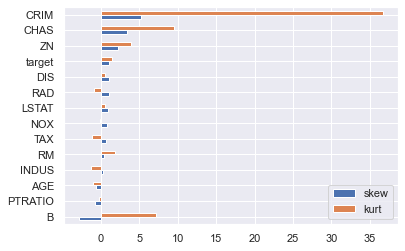

In [11]:
sk_df.sort_values('skew').plot(kind='barh')

# df ver01 : scale

## X scale : 효과 낮음

In [12]:
scale = StandardScaler()

scale.fit(X_train)
X_train_sc = scale.transform(X_train)
X_test_sc  = scale.transform(X_test)

In [13]:
X_train.shape, X_test.shape

((404, 13), (102, 13))

In [14]:
pd.DataFrame(X_train_sc).isna().sum().sum()

0

In [15]:
# ------------------------------
X_train = X_train_sc
X_test  = X_test_sc
y_train = y_train
y_test  = y_test
# ------------------------------

models = [LinearRegression(),
          Ridge(),
          Lasso(),
          ElasticNet(),
          DecisionTreeRegressor(),
          XGBRegressor(),
          LGBMRegressor(),
          ]

for model in models:
    print(model.__class__.__name__)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    print('MSE  =', mse)
    print('RMES =', rmse)
    print('-' * 30)

LinearRegression
MSE  = 33.448979997676496
RMES = 5.783509315085133
------------------------------
Ridge
MSE  = 33.5371130739407
RMES = 5.791123645195352
------------------------------
Lasso
MSE  = 40.14696456446331
RMES = 6.336163236885813
------------------------------
ElasticNet
MSE  = 42.87871149007003
RMES = 6.548183831419979
------------------------------
DecisionTreeRegressor
MSE  = 30.898823529411764
RMES = 5.558671021873103
------------------------------
XGBRegressor
MSE  = 21.36472443696006
RMES = 4.622199091012854
------------------------------
LGBMRegressor
MSE  = 24.5098863728449
RMES = 4.950746042047087
------------------------------


## y scale : 큰 개선 (4~100)

In [16]:
y_train.shape

(404,)

In [17]:
np.array(y_train).shape

(404,)

In [18]:
np.array(y_train).reshape(-1, 1).shape

(404, 1)

In [19]:
scale = StandardScaler()

scale.fit(np.array(y_train).reshape(-1, 1))
y_train_sc = pd.DataFrame(scale.transform(np.array(y_train).reshape(-1, 1)))
y_test_sc  = pd.DataFrame(scale.transform(np.array(y_test).reshape(-1, 1)))

In [20]:
y_train_sc.shape, y_test_sc.shape

((404, 1), (102, 1))

In [21]:
# ------------------------------
X_train = X_train
X_test  = X_test
y_train = y_train_sc
y_test  = y_test_sc
# ------------------------------

models = [LinearRegression(),
          Ridge(),
          Lasso(),
          ElasticNet(),
          DecisionTreeRegressor(),
          XGBRegressor(),
          LGBMRegressor(),
          ]

for model in models:
    print(model.__class__.__name__)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    print('MSE  =', mse)
    print('RMES =', rmse)
    print('-' * 30)

LinearRegression
MSE  = 0.3928531653288211
RMES = 0.6267799975500343
------------------------------
Ridge
MSE  = 0.3938882748593052
RMES = 0.6276051902743517
------------------------------
Lasso
MSE  = 0.9581718678127248
RMES = 0.9788625377512027
------------------------------
ElasticNet
MSE  = 0.7259495522082012
RMES = 0.8520267320971808
------------------------------
DecisionTreeRegressor
MSE  = 0.4218000735310239
RMES = 0.649461371854419
------------------------------
XGBRegressor
MSE  = 0.2428194657384344
RMES = 0.4927671516430802
------------------------------
LGBMRegressor
MSE  = 0.2878648739017904
RMES = 0.5365304035204252
------------------------------


## X, y scale : y scale과 유사 -> y는 반드시 scale

In [22]:
# ------------------------------
X_train = X_train_sc
X_test  = X_test_sc
y_train = y_train_sc
y_test  = y_test_sc
# ------------------------------

models = [LinearRegression(),
          Ridge(),
          Lasso(),
          ElasticNet(),
          DecisionTreeRegressor(),
          XGBRegressor(),
          LGBMRegressor(),
          ]

for model in models:
    print(model.__class__.__name__)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    print('MSE  =', mse)
    print('RMES =', rmse)
    print('-' * 30)

LinearRegression
MSE  = 0.3928531653288211
RMES = 0.6267799975500343
------------------------------
Ridge
MSE  = 0.3938882748593052
RMES = 0.6276051902743517
------------------------------
Lasso
MSE  = 0.9581718678127248
RMES = 0.9788625377512027
------------------------------
ElasticNet
MSE  = 0.7259495522082012
RMES = 0.8520267320971808
------------------------------
DecisionTreeRegressor
MSE  = 0.39032503398906576
RMES = 0.6247599811039962
------------------------------
XGBRegressor
MSE  = 0.2428194657384344
RMES = 0.4927671516430802
------------------------------
LGBMRegressor
MSE  = 0.2878648739017904
RMES = 0.5365304035204252
------------------------------


## scaled skew

<AxesSubplot:>

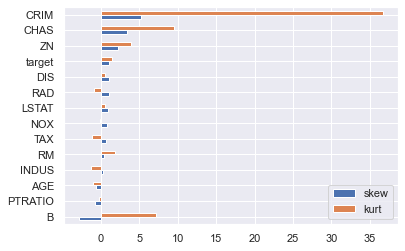

In [23]:
train_sc = pd.concat([pd.DataFrame(X_train_sc), y_train_sc], axis=1)
test_sc  = pd.concat([pd.DataFrame(X_test_sc), y_test_sc], axis=1)
df01 = pd.concat([train_sc, test_sc])

sk_df01 = pd.DataFrame({'skew':skew(df01), 'kurt':kurtosis(df01)},
                     index=df.columns)
sk_df01.sort_values('skew').plot(kind='barh')

# df ver02 : log scale + scale, y scale보다 더 개선

In [24]:
boston = datasets.load_boston()
df = pd.DataFrame(data=boston['data'], columns=boston['feature_names'])
df['target'] = boston['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

In [25]:
X_train_log = np.log1p(X_train)
X_test_log  = np.log1p(X_test)
y_train_log = np.log1p(y_train)
y_test_log  = np.log1p(y_test)

In [26]:
scale = StandardScaler()

scale.fit(X_train_log)
X_train_sc = pd.DataFrame(scale.transform(X_train_log))
X_test_sc  = pd.DataFrame(scale.transform(X_test_log))

scale.fit(np.array(y_train_log).reshape(-1, 1))
y_train_sc = pd.DataFrame(scale.transform(np.array(y_train_log).reshape(-1, 1)))
y_test_sc  = pd.DataFrame(scale.transform(np.array(y_test_log).reshape(-1, 1)))

In [27]:
# ------------------------------
X_train = X_train_sc
X_test  = X_test_sc
y_train = y_train_sc
y_test  = y_test_sc
# ------------------------------

models = [LinearRegression(),
          Ridge(),
          Lasso(),
          ElasticNet(),
          DecisionTreeRegressor(),
          XGBRegressor(),
          LGBMRegressor(),
          ]

for model in models:
    print(model.__class__.__name__)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    print('MSE  =', mse)
    print('RMES =', rmse)
    print('-' * 30)

LinearRegression
MSE  = 0.318315074428947
RMES = 0.5641941814915739
------------------------------
Ridge
MSE  = 0.31938057066194814
RMES = 0.5651376563828924
------------------------------
Lasso
MSE  = 0.8853330765838622
RMES = 0.9409213976650027
------------------------------
ElasticNet
MSE  = 0.6345594614274273
RMES = 0.796592406081948
------------------------------
DecisionTreeRegressor
MSE  = 0.2638063289118615
RMES = 0.51362080264711
------------------------------
XGBRegressor
MSE  = 0.18946445862350153
RMES = 0.435275152775232
------------------------------
LGBMRegressor
MSE  = 0.21997174299967448
RMES = 0.4690114529514972
------------------------------
